**Desarrollo del enigma**

**Configuración del entorno**
Instalación y carga de las bibliotecas y dependencias necesarias (p. ej. pandas, NumPy, SciPy).

**Carga y validación de datos**
Importación del conjunto de datos, verificación de su integridad y formato, y detección de posibles valores faltantes.

**Análisis exploratorio**
Estudio de la distribución de las variables, identificación de duplicados y detección de valores atípicos (outliers).

**Preprocesamiento**
Limpieza de datos: eliminación de duplicados, tratamiento de outliers y normalización o estandarización de atributos.

**Selección de variables**
Análisis de correlaciones y eliminación de features redundantes para mejorar la calidad del modelo.

**Modelado y validación**
Entrenamiento de modelos predictivos, ajuste de hiperparámetros y evaluación mediante métricas adecuadas.

**Interpretación de resultados**
Presentación de conclusiones, visualizaciones clave y recomendaciones basadas en los hallazgos.

In [1]:
import sys
import os
import importlib
import warnings
warnings.filterwarnings('ignore')
print(f" ><>< Directorio actual: {os.getcwd()}  ><>< ")
def get_environment_name():
    if 'CONDA_DEFAULT_ENV' in os.environ:
        return os.environ['CONDA_DEFAULT_ENV']
    elif 'VIRTUAL_ENV' in os.environ:
        return os.path.basename(os.environ['VIRTUAL_ENV'])
    elif 'conda' in sys.executable.lower():
        path_parts = sys.executable.split(os.sep)
        if 'envs' in path_parts:
            env_index = path_parts.index('envs')
            if env_index + 1 < len(path_parts):
                return path_parts[env_index + 1]
        return 'base'
    else:
        return 'sistema (sin entorno virtual)'
env_name = get_environment_name()
print(f" ><>< Nombre del entorno: {env_name} ><><><")
packages_to_check = [
    'pandas',
    'numpy', 
    'matplotlib',
    'seaborn',
    'plotly',
    'sklearn',
    'boto3',
    'jupyter',
    'ipykernel',
    'xgboost'
]

installed_packages = {}
missing_packages = []

for package_name in packages_to_check:
        if package_name == 'sklearn':
            import sklearn as pkg
        else:
            pkg = importlib.import_module(package_name)
        
        version = getattr(pkg, '__version__', 'ok')
        installed_packages[package_name] = version
        print(f" {package_name:12} v{version}")

#Orden al estilo P8P
# Librería estándar de Python
from collections import Counter
from datetime import datetime, timedelta
from io import StringIO
import warnings
import time  


# Dependencias de terceros
# AWS
import boto3
# Ciencia de datos
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt   
#Series de tiempo
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
# Aprendizaje automático clásico
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN, SMOTE, SMOTENC
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.ensemble import (
    GradientBoostingClassifier,
    RandomForestClassifier,
    VotingClassifier,
)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    average_precision_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,auc
)
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import lightgbm as lgb
# XGBoost
import xgboost as xgb
from xgboost import XGBClassifier, callback
# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')
print("Etapa Verificación de bibliotecas en Kernel : ✓")

 ><>< Directorio actual: c:\Users\usuario\Desktop\meli_reto3  ><>< 
 ><>< Nombre del entorno: ml_permanente ><><><
 pandas       v2.2.3
 numpy        v1.26.4
 matplotlib   v3.10.0
 seaborn      v0.13.2
 plotly       v6.2.0
 sklearn      v1.6.1
 boto3        v1.39.9
 jupyter      vok
 ipykernel    v6.29.5
 xgboost      v3.0.2
Etapa Verificación de bibliotecas en Kernel : ✓


In [2]:
cred_df = pd.read_csv(r"C:\Users\usuario\Downloads\sanmi_accessKeys.csv")
aws_access_key_id     = cred_df.loc[0, 'Access key ID']
aws_secret_access_key = cred_df.loc[0, 'Secret access key']

In [3]:
s3 = boto3.client(
    's3',
    aws_access_key_id=aws_access_key_id,
    aws_secret_access_key=aws_secret_access_key,
    region_name='us-east-2'
)

In [4]:
BUCKET_NAME  = "aws-sam-cli-managed-default-samclisourcebucket-ko8qnsdeyujb"
OBJECT_KEY  = "elbaldedejuan/DS_MeLi/full_devices.csv"
s3 = boto3.client("s3")
def read_s3_csv(bucket: str, key: str) -> pd.DataFrame:
    """Descarga un CSV pequeño/mediano desde S3 y lo lee en un DataFrame."""
    obj = s3.get_object(Bucket=bucket, Key=key)
    csv_content = obj["Body"].read().decode("latin1")
    return pd.read_csv(StringIO(csv_content))
df    = read_s3_csv(BUCKET_NAME, OBJECT_KEY)
print("Conexión con datos en nube : ✓")

Conexión con datos en nube : ✓


> Primer encuentro con data frame

In [5]:
df

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...
124489,2015-11-02,Z1F0MA1S,0,18310224,0,0,0,10,353705,8,8,0
124490,2015-11-02,Z1F0Q8RT,0,172556680,96,107,4,11,332792,0,0,13
124491,2015-11-02,Z1F0QK05,0,19029120,4832,0,0,11,350410,0,0,0
124492,2015-11-02,Z1F0QL3N,0,226953408,0,0,0,12,358980,0,0,0


> Vamos a realizar un proceso de revisión de los atributos y explorar si tenemos algún tipo de valor duplicado, faltante, o outliers que pudiesen atacar negativamente nuetros modelos

In [6]:
attr_cols = [c for c in df.columns if c.startswith("attribute")]
corr = df[attr_cols].corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
high_corr = (
    upper
    .stack()
    .reset_index()
    .rename(columns={'level_0':'var1','level_1':'var2',0:'corr'})
    .query('corr > 0.8')
)
print("=== Pares con |corr|>0.8 ===")
print(high_corr.to_string(index=False))
to_drop = set(high_corr['var2'])
print(f"\nColumnas a eliminar por correlación: {sorted(to_drop)}")
dupe_full = df.duplicated(keep='first')
print(f"\nFilas duplicadas completas a borrar: {dupe_full.sum()}")
bounds = {}
outlier_masks = {}
for col in attr_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 2*IQR, Q3 + 2*IQR
    bounds[col] = (lower, upper)
    outlier_masks[col] = (df[col] < lower) | (df[col] > upper)
outlier_df = pd.DataFrame(outlier_masks)
df['outlier_count'] = outlier_df.sum(axis=1)
print(f"Filas con >4 outliers a borrar: {(df['outlier_count'] > 4).sum()}")


=== Pares con |corr|>0.8 ===
      var1       var2  corr
attribute7 attribute8   1.0

Columnas a eliminar por correlación: ['attribute8']

Filas duplicadas completas a borrar: 1
Filas con >4 outliers a borrar: 132


In [7]:
df = (
    df
    .drop(columns=list(to_drop))
    .loc[~dupe_full]
    .loc[lambda d: d['outlier_count'] <= 4]
    .drop(columns=['outlier_count'])
    .reset_index(drop=True)
)

> En este tipo de enigmas es fundamental revisar cómo se comporta el balanceo de la variable objetivo:

In [8]:
print(f"Dimensiones del dataset: {df.shape}")
print(f"Dispositivos únicos: {df['device'].nunique()}")
print(f"Rango de fechas: {df['date'].min()} a {df['date'].max()}")
if not pd.api.types.is_datetime64_any_dtype(df['date']):
    df['date'] = pd.to_datetime(df['date'])
failure_dist = df['failure'].value_counts(normalize=True) * 100
print(f"\nDistribución de fallas:")
print(f"No falla (0): {failure_dist[0]:.1f}%")
print(f"Falla (1): {failure_dist[1]:.1f}%")
print(f"Ratio de desbalance: {failure_dist[0]/failure_dist[1]:.1f}:1")

Dimensiones del dataset: (124361, 11)
Dispositivos únicos: 1163
Rango de fechas: 2015-01-01 a 2015-11-02

Distribución de fallas:
No falla (0): 99.9%
Falla (1): 0.1%
Ratio de desbalance: 1308.1:1


> Dado el balanceo tan pronunciado en este data set, se requiere activar un plan de acción apropiado, el cual vamos s tratar con oversampleo y características de los modelos que veremos mas adelante

In [9]:
def preparandonos(df):
    df['date'] = pd.to_datetime(df['date'])
    df['year'] = df['date'].dt.year    
    df['month'] = df['date'].dt.month
    df['dayofweek']  = df['date'].dt.dayofweek
    df['day']   = df['date'].dt.day
    df['hour']  = df['date'].dt.hour
    X = df.drop(['failure', 'date'], axis=1)
    y = df['failure']
    categorical_columns = []
    for col in X.columns:
        if (X[col].dtype == 'object' or 
            (X[col].dtype in ['int64', 'float64'] and X[col].nunique() < 10) or
            col.lower() in ['device', 'type', 'category', 'class']):
            categorical_columns.append(col)   
    print(f"Categóricas: {categorical_columns}")
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"   - {col}: {X[col].nunique()} categorías únicas")
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    cat_idx = [X.columns.get_loc(col) for col in categorical_columns]   
    return X_train, X_test, y_train, y_test, cat_idx, categorical_columns, label_encoders
def evaluando_modeloS(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    pr_auc = auc(recall, precision)   
    return {
        'precision': report['1']['precision'],
        'recall': report['1']['recall'],
        'f1': report['1']['f1-score'],
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'classification_report': report
    }
def revision_ratios(X_train, y_train, X_test, y_test, cat_idx, categorical_columns):
    strategies = [
        ('no_balance', None, None),
        ('smote_1pct', 'smote', 0.01),
        ('smote_2pct', 'smote', 0.02),
        ('smote_5pct', 'smote', 0.05),
        ('smote_10pct', 'smote', 0.1),
        ('smote_20pct', 'smote', 0.2),
        ('smotenc_1pct', 'smotenc', 0.01), 
        ('smotenc_2pct', 'smotenc', 0.02),
        ('smotenc_5pct', 'smotenc', 0.05),
        ('smotenc_10pct', 'smotenc', 0.1),
        ('class_weight', 'class_weight', 'balanced'),
        ('undersampling', 'undersample', 0.1),
        ('smote_tomek', 'smote_tomek', 0.05),
        ('smotenc_tomek', 'smotenc_tomek', 0.05) 
    ]   
    results = {}   
    print("Experimentando con diferentes estrategias de balanceado...")
    for name, method, param in strategies:
        print(f"Revisando el --> {name}")        
        try:
            if method is None:
                model = RandomForestClassifier(random_state=42, n_estimators=100)
                X_final, y_final = X_train, y_train               
            elif method == 'class_weight':
                model = RandomForestClassifier(
                    class_weight='balanced', 
                    random_state=42, 
                    n_estimators=100
                )
                X_final, y_final = X_train, y_train              
            elif method == 'smote':
                if len(cat_idx) == 0:
                    sampler = SMOTE(
                        sampling_strategy=param,
                        random_state=42
                    )
                    X_final, y_final = sampler.fit_resample(X_train, y_train)
                else:
                    print(f"SMOTE regular")
                    continue
                model = RandomForestClassifier(random_state=42, n_estimators=100)          
            elif method == 'smotenc':
                if len(cat_idx) > 0:
                    sampler = SMOTENC(
                        categorical_features=cat_idx,
                        sampling_strategy=param,
                        random_state=42,
                        k_neighbors=5
                    )
                    X_final, y_final = sampler.fit_resample(X_train, y_train)
                else:
                    print(f"  Saltando SMOTENC - no hay variables categóricas")
                    continue
                model = RandomForestClassifier(random_state=42, n_estimators=100)         
            elif method == 'undersample':
                sampler = RandomUnderSampler(
                    sampling_strategy=param,
                    random_state=42
                )
                X_final, y_final = sampler.fit_resample(X_train, y_train)
                model = RandomForestClassifier(random_state=42, n_estimators=100)            
            elif method == 'smote_tomek':
                if len(cat_idx) == 0:
                    sampler = SMOTETomek(
                        sampling_strategy=param,
                        random_state=42
                    )
                    X_final, y_final = sampler.fit_resample(X_train, y_train)
                else:
                    print(f"Saltando SMOTE-Tomek")
                    continue
                model = RandomForestClassifier(random_state=42, n_estimators=100)               
            elif method == 'smotenc_tomek':
                if len(cat_idx) > 0:
                    sampler = SMOTETomek(
                        smote=SMOTENC(
                            categorical_features=cat_idx,
                            sampling_strategy=param,
                            random_state=42
                        ),
                        random_state=42
                    )
                    X_final, y_final = sampler.fit_resample(X_train, y_train)
                else:
                    print(f" Saltando SMOTENC-Tomek - no hay variables categóricas")
                    continue
                model = RandomForestClassifier(random_state=42, n_estimators=100)
            model.fit(X_final, y_final)
            result = evaluando_modeloS(model, X_test, y_test)
            result['train_samples'] = len(X_final)
            result['train_positive_ratio'] = y_final.sum() / len(y_final)
            result['method_type'] = method   
            results[name] = result
            print(f"Completado - F1: {result['f1']:.3f}, Recall: {result['recall']:.3f}")          
        except Exception as e:
            print(f" Fallamos: {str(e)}")
            continue
    return results
def impacto_strs(X_train, y_train, categorical_columns):
    if len(categorical_columns) == 0:
        print("Categoricas NULL")
        return
    print(f"\nANÁLISIS DE VARIABLES CATEGÓRICAS")   
def plot_results(results):
    methods = list(results.keys())
    metrics = ['precision', 'recall', 'f1', 'roc_auc', 'pr_auc']
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.flatten()
    colors = []
    for method in methods:
        if 'smotenc' in method:
            colors.append('#FF6B6B')  
        elif 'smote' in method:
            colors.append('#4ECDC4')  
        elif 'class_weight' in method:
            colors.append('#45B7D1')  
        elif 'undersamp' in method:
            colors.append('#96CEB4')  
        else:
            colors.append('#FFEAA7') 
    for i, metric in enumerate(metrics):
        values = [results[method][metric] for method in methods] 
        bars = axes[i].bar(range(len(methods)), values, color=colors, alpha=0.8)
        axes[i].set_title(f'{metric.upper().replace("_", " ")}', fontsize=14, fontweight='bold')
        axes[i].set_xticks(range(len(methods)))
        axes[i].set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
        axes[i].set_ylim(0, 1)
        axes[i].grid(True, alpha=0.3)
        for j, v in enumerate(values):
            axes[i].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)
    train_samples = [results[method]['train_samples'] for method in methods]
    bars = axes[5].bar(range(len(methods)), train_samples, color=colors, alpha=0.8)
    axes[5].set_title('Training Samples', fontsize=14, fontweight='bold')
    axes[5].set_xticks(range(len(methods)))
    axes[5].set_xticklabels(methods, rotation=45, ha='right', fontsize=10)
    axes[5].grid(True, alpha=0.3)
    for j, v in enumerate(train_samples):
        axes[5].text(j, v + max(train_samples)*0.01, f'{v}', ha='center', va='bottom', fontsize=9) 
    plt.tight_layout()
    plt.show()
def tablita_resumen(results):       
    print("\nRESUMEN DE RESULTADOS")
    summary_data = []
    for method, result in results.items():
        method_type = "SMOTENC" if 'smotenc' in method else (
                     "SMOTE" if 'smote' in method else (
                     "Class Weight" if 'class_weight' in method else (
                     "Undersample" if 'undersamp' in method else "Otros")))
        summary_data.append({
            'Método': method,
            'Tipo': method_type,
            'Precision': f"{result['precision']:.3f}",
            'Recall': f"{result['recall']:.3f}",
            'F1-Score': f"{result['f1']:.3f}",
            'ROC-AUC': f"{result['roc_auc']:.3f}",
            'PR-AUC': f"{result['pr_auc']:.3f}",
            'Muestras': result['train_samples'],
            'Ratio+': f"{result['train_positive_ratio']:.3f}"
        })  
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    best_f1 = max(results.keys(), key=lambda x: results[x]['f1'])
    best_recall = max(results.keys(), key=lambda x: results[x]['recall'])
    best_precision = max(results.keys(), key=lambda x: results[x]['precision'])
    
    print(f"\nMEJORES MÉTODOS:")
    print(f"F1-Score: {best_f1} ({results[best_f1]['f1']:.3f})")
    print(f"Recall: {best_recall} ({results[best_recall]['recall']:.3f})")
    print(f"Precision: {best_precision} ({results[best_precision]['precision']:.3f})")
def experimento(df):
    print("INICIANDO EXPERIMENTACIÓN DE BALANCEADO CON SMOTENC")
    print("Preparando datos...")
    X_train, X_test, y_train, y_test, cat_idx, categorical_columns, label_encoders = preparandonos(df)
    print(f"   - Muestras entrenamiento: {len(X_train)}")
    print(f"   - Muestras test: {len(X_test)}")
    print(f"   - Variables categóricas: {len(cat_idx)}")
    print(f"   - Ratio original de fallos: {y_train.sum()/len(y_train):.4f}")
    impacto_strs(X_train, y_train, categorical_columns)
    results = revision_ratios(X_train, y_train, X_test, y_test, cat_idx, categorical_columns)
    tablita_resumen(results)
    plot_results(results)
    return results, categorical_columns, label_encoders

In [10]:
def innge_de_features(df):
    print("\nHaremos un poco de Ingeniería de Features") 
    df = df.sort_values(['device', 'month', 'day', 'hour']).reset_index(drop=True)
    df['timestamp'] = df.groupby('device').cumcount()
    attributes = [col for col in df.columns if col.startswith('attribute')]
    featured_data = []    
    for device in df['device'].unique():
        device_data = df[df['device'] == device].copy().sort_values(['month', 'day', 'hour'])
        for attr in attributes:
            device_data[f'{attr}_lag1'] = device_data[attr].shift(1)
            device_data[f'{attr}_lag2'] = device_data[attr].shift(2)
            device_data[f'{attr}_ma3'] = device_data[attr].rolling(window=3, min_periods=1).mean()
            device_data[f'{attr}_ma7'] = device_data[attr].rolling(window=7, min_periods=1).mean()
            device_data[f'{attr}_std3'] = device_data[attr].rolling(window=3, min_periods=1).std()
            device_data[f'{attr}_diff'] = device_data[attr].diff()
            pct_change = device_data[attr].pct_change()
            pct_change = pct_change.replace([np.inf, -np.inf], 0)
            pct_change = pct_change.fillna(0)
            pct_change = pct_change.clip(-5, 5)
            device_data[f'{attr}_pct_change'] = pct_change
            device_data[f'{attr}_trend'] = device_data[attr] - device_data[f'{attr}_ma7']          
        featured_data.append(device_data)
    df_featured = pd.concat(featured_data, ignore_index=True)
    numeric_columns = df_featured.select_dtypes(include=[np.number]).columns
    for col in numeric_columns:
        df_featured[col] = df_featured[col].replace([np.inf, -np.inf], np.nan)
    df_featured = df_featured.fillna(method='ffill').fillna(method='bfill').fillna(0)
    df_featured = df_featured.dropna()    
    print(f"Dataset con features: {df_featured.shape}")
    print(f"Nuevas features creadas: {df_featured.shape[1] - df.shape[1]}")
    print(f"Distribución final: {Counter(df_featured['failure'])}")    
    return df_featured


**Random Forest**
Modelo de bosque aleatorio con énfasis en evitar el sobreajuste y tratar el desbalance.
Parámetros clave:

- class_weight="balanced": ajusta automáticamente los pesos de clase inversamente proporcional a sus frecuencias.

- max_depth=4, min_samples_split=30, min_samples_leaf=20: controlan la complejidad para reducir el sobreajuste.

- max_features=0.4, n_estimators=200: promueven diversidad y estabilidad en los árboles

**XGBoost**
Modelo de boosting robusto con partición estratificada y regularización explícita.
Parámetros clave:

- scale_pos_weight=ratio: compensa clases desbalanceadas usando la proporción entre clases

- reg_alpha=2.0, reg_lambda=2.0, gamma=2.0: aplican regularización L1/L2 y control de complejidad

- subsample=0.7, colsample_bytree=0.5: reducen el riesgo de sobreajuste

- eval_metric="auc": métrica adecuada para clasificación desbalanceada

**Gradient Boosting**
Boosting clásico con pesos de clase explícitos y poda controlada.
Parámetros clave:

- sample_weight=compute_sample_weight('balanced', y_train): pondera el entrenamiento según distribución de clases.

- max_depth=3, min_samples_leaf=15: previene árboles demasiado específicos.

- subsample=0.7: introduce aleatoriedad para mayor generalización

**HistGradientBoosting**
Versión eficiente de boosting con histogramas y control granular del desbalance.
Parámetros clave:

- class_weight={0: 1.0, 1: ratio*1.10}: aumenta ligeramente el peso de la clase minoritaria.

- early_stopping=True y validation_fraction=0.15: detiene el entrenamiento ante sobreajuste.

- l2_regularization=5.0: penaliza modelos complejos para generalizar mejor

**LightGBM Regularizado**
Boosting basado en histogramas y hojas, con énfasis en generalización para clases desbalanceadas.
Parámetros clave:

- scale_pos_weight=ratio: compensa el desbalance de clases.

- early_stopping y eval_metric="aucpr": evalúa la capacidad del modelo con métricas robustas para desbalance.

- reg_alpha=1.0, reg_lambda=1.0: regularización L1 y L2 para evitar sobreajuste

**Ensamble Regularizado**
Combinación de Random Forest, XGBoost y HistGradientBoosting para robustez y diversidad.
Parámetros clave:

- VotingClassifier(voting='soft'): pondera probabilidades para una mejor agregación.

- Submuestreo del 70% de los datos para entrenamiento (X_sub): mejora generalización.

- Cada modelo base ha sido previamente ajustado para desbalance con técnicas propias.


In [11]:
def modelo_rfc(X_train, y_train, *, rs=42):
    model = RandomForestClassifier(
        n_estimators      = 200,
        max_depth         = 4,
        min_samples_split = 30,
        min_samples_leaf  = 20,
        max_features      = 0.4,
        class_weight      = "balanced",
        bootstrap         = True,
        oob_score         = True,
        random_state      = rs,
        n_jobs            = -1
    )
    model.fit(X_train, y_train)
    return model
def modelo_xgb(X_train, y_train, *, rs=42, test_size=0.2):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train, test_size=test_size,
        stratify=y_train, random_state=rs
    )
    ratio = (y_tr == 0).sum() / (y_tr == 1).sum()
    model = XGBClassifier(
        n_estimators      = 400,     
        learning_rate     = 0.05,
        max_depth         = 3,
        min_child_weight  = 10,
        subsample         = 0.7,
        colsample_bytree  = 0.5,
        reg_alpha         = 2.0,
        reg_lambda        = 2.0,
        gamma             = 2.0,
        scale_pos_weight  = ratio,
        eval_metric       = "auc",  
        random_state      = rs,
        n_jobs            = -1
    )
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False               
    )
    return model
def modelo_gb(X_train, y_train, *, rs=42):
    sw = compute_sample_weight('balanced', y_train)
    model = GradientBoostingClassifier(
        n_estimators      = 200,
        learning_rate     = 0.05,
        max_depth         = 3,
        subsample         = 0.7,
        min_samples_split = 30,
        min_samples_leaf  = 15,
        max_features      = 'sqrt',
        random_state      = rs
    )
    model.fit(X_train, y_train, sample_weight=sw)
    return model
def modelo_hgb(X_train, y_train, *, rs=42):
    ratio = (y_train == 0).sum() / (y_train == 1).sum()
    model = HistGradientBoostingClassifier(
        loss               = "log_loss",
        learning_rate      = 0.015,
        max_iter           = 600,
        early_stopping     = True,
        validation_fraction= 0.15,
        n_iter_no_change   = 30,
        max_leaf_nodes     = 31,
        min_samples_leaf   = 20,
        l2_regularization  = 5.0,
        max_bins           = 128,
        class_weight       = {0:1.0, 1:ratio*1.10},
        random_state       = rs
    )
    model.fit(X_train, y_train)
    return model
def modelo_lgbm(X_train, y_train, *, rs=42, test_size=0.2):
    X_tr, X_val, y_tr, y_val = train_test_split(
        X_train, y_train,
        test_size=test_size,
        stratify=y_train,
        random_state=rs
    )
    ratio = (y_tr == 0).sum() / (y_tr == 1).sum()
    model = lgb.LGBMClassifier(
        n_estimators      = 1000,
        learning_rate     = 0.02,
        max_depth         = 3,
        subsample         = 0.6,
        colsample_bytree  = 0.6,
        min_child_samples = 20,
        min_child_weight  = 10,
        reg_alpha         = 1.0,
        reg_lambda        = 1.0,
        scale_pos_weight  = ratio,
        objective         = "binary",
        random_state      = rs,
        n_jobs            = -1,
        verbose           = -1   
    )
    es_cb = lgb.early_stopping(stopping_rounds=50)
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        eval_metric="aucpr",
        callbacks=[es_cb]
    )
    best_trees = model.best_iteration_
    model.set_params(n_estimators=best_trees)

    return model
def ensamblandoAndo(X_train, y_train, *, rs=42):
    idx = np.random.choice(len(X_train),
                           int(len(X_train)*0.7),
                           replace=False)
    X_sub, y_sub = X_train.iloc[idx], y_train.iloc[idx]

    base_models = [
        ('rf', modelo_rfc(X_sub, y_sub, rs=rs)),
        ('xgb', modelo_xgb(X_sub, y_sub, rs=rs)),
        ('hgb', modelo_hgb(X_sub, y_sub, rs=rs))
    ]
    ensemble = VotingClassifier(
        estimators=base_models,
        voting='soft',
        n_jobs=-1
    )
    ensemble.fit(X_sub, y_sub)
    return ensemble, dict(base_models)
    


In [12]:
def evaluacion(model, X_train, y_train, X_test, y_test):
    resultado = {
        "metrics": {},
        "times":   {},
        "predictions": None,
        "probabilities": None,
        "confusion_matrix_train": None,
        "confusion_matrix_test":  None
    }
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    resultado["times"]["fit_time"] = time.perf_counter() - t0
    t0 = time.perf_counter()
    y_pred_train = model.predict(X_train)
    resultado["times"]["pred_time_train"] = time.perf_counter() - t0
    t0 = time.perf_counter()
    y_pred_test = model.predict(X_test)
    resultado["times"]["pred_time_test"] = time.perf_counter() - t0
    resultado["predictions"] = y_pred_test
    y_prob_train = y_prob_test = None
    if hasattr(model, "predict_proba"):
        y_prob_train = model.predict_proba(X_train)[:, 1]
        y_prob_test  = model.predict_proba(X_test)[:, 1]
    resultado["probabilities"] = y_prob_test
    def _metrics(y_true, y_pred, y_prob=None):
        d = dict(
            precision = precision_score(y_true, y_pred, zero_division=0),
            recall    = recall_score(y_true, y_pred, zero_division=0),
            f1        = f1_score(y_true, y_pred, zero_division=0),
            auc       = roc_auc_score(y_true, y_prob) if y_prob is not None else np.nan
        )
        return d
    metrics_train = _metrics(y_train, y_pred_train, y_prob_train)
    metrics_test  = _metrics(y_test,  y_pred_test,  y_prob_test)
    metrics_train = {f"{k}_train": v for k, v in metrics_train.items()}
    resultado["metrics"].update(metrics_train)
    resultado["metrics"].update(metrics_test)  
    resultado["confusion_matrix_train"] = confusion_matrix(y_train, y_pred_train)
    resultado["confusion_matrix_test"]  = confusion_matrix(y_test,  y_pred_test)
    print((
        f"Fit {resultado['times']['fit_time']:.3f}s | "
        f"Train F1 {metrics_train['f1_train']:.3f} – "
        f"Test F1 {metrics_test['f1']:.3f}"
    ))
    return resultado
def comparacion(models_dict, X_train, y_train, X_test, y_test):
    rows = []
    for name, model in models_dict.items():
        print(f"\n>>> Evaluando {name}")
        res = evaluacion(model, X_train, y_train, X_test, y_test)
        if res is None:
            print(f"  ✗ {name} falló.")
            continue
        row = {**res["metrics"], **res["times"], "model": name}
        rows.append(row)
    if not rows:
        print("No se pudo evaluar ningún modelo.")
        return None, None, None
    df = pd.DataFrame(rows).set_index("model").fillna(0)
    weights = {"auc": 0.30, "f1": 0.25, "recall": 0.25, "precision": 0.20}
    df["weighted_score"] = sum(df[m] * w for m, w in weights.items())

    print("\n=== Tabla comparativa ===")
    display(df.round(3)[[
        "precision_train", "recall_train", "f1_train", "auc_train",
        "precision",       "recall",       "f1",       "auc",
        "weighted_score",  "fit_time"
    ]])
    best_name   = df["weighted_score"].idxmax()
    best_model  = models_dict[best_name]
    best_result = df.loc[best_name].to_dict()
    print(f"\nMejor modelo: {best_name} (score {best_result['weighted_score']:.3f})")
    return best_model, best_result, df


In [13]:
def prediciendo_el_futuro_sklearn(
    model,
    scaler,
    df,
    device_id,
    feature_cols,
    seq_len=5,
    thresh=0.5,
    date_col="timestamp"
):
    if date_col not in df.columns:
        raise KeyError(f"'{date_col}' no está en el DataFrame")
    hist = (
        df[df["device"] == device_id]
          .sort_values(date_col)
          .reset_index(drop=True)
    )
    if hist.empty:
        raise ValueError(f"Dispositivo '{device_id}' no encontrado")
    window = hist.tail(seq_len).copy()
    if len(window) < seq_len:
        pad = pd.concat([window.iloc[[0]]] * (seq_len - len(window)),
                        ignore_index=True)
        window = pd.concat([pad, window], ignore_index=True)
    if window[feature_cols].isnull().any().any():
        window[feature_cols] = (
            window[feature_cols]
              .fillna(method="ffill")
              .fillna(0)
        )

    model_feats  = list(getattr(model, "feature_names_in_", []))
    scaler_feats = list(getattr(scaler, "feature_names_in_", []))
    if not model_feats or not scaler_feats:
        raise ValueError("Modelo o scaler sin `feature_names_in_`")


    missing = [c for c in scaler_feats if c not in window.columns]
    if missing:
        raise KeyError(f"Faltan columnas para el scaler: {missing}")

    X_full_last   = window[scaler_feats].iloc[[-1]].astype("float32")
    X_scaled_full = scaler.transform(X_full_last.values)
    idx           = [scaler_feats.index(f) for f in model_feats]
    X_scaled      = X_scaled_full[:, idx]
    proba = model.predict_proba(X_scaled)[0, 1]
    pred  = int(proba >= thresh)

    last_ts = window[date_col].iloc[-1]
    if pd.api.types.is_datetime64_any_dtype(window[date_col]):
        next_step = last_ts + pd.Timedelta(days=1)
    else:
        # numérico (p.ej. cumcount): sumar 1
        next_step = int(last_ts) + 1

    # Devuelve un DataFrame de una fila
    return pd.DataFrame([{
        "device":         device_id,
        "next_step":      next_step,
        "probability":    float(proba),
        "pred_class":     pred,
        "confidence":     abs(proba - 0.5) * 2
    }])


En este segmento vamos a preparar los datos de series temporales, probar distintas técnicas de balanceo de clases con un Random Forest y comparar sus resultados de forma clara y visual:

La función preparandonos agarra el DataFrame original, arregla las variables que pueden dañar un proceso de entrenamiento para el balanceo,  separa variables predictoras y etiqueta, detecta y codifica automáticamente las variables categóricas con LabelEncoder, y finalmente divide los datos en entrenamiento y prueba, devolviendo además los índices y nombres de las columnas categóricas junto con los codificadores.

Con evaluando_modeloS , se generan predicciones y probabilidades, a partir de las cuales calcula las métricas clave (precision, recall, F1‑score, ROC‑AUC, PR‑AUC), la matriz de confusión y el informe de clasificación, retornándolas en un diccionario estructurado.

La función revision_ratios vamos a recorrer un conjunto de estrategias de **balanceo** (sin balanceo alguno que dañe nuestros modelos, SMOTE y variantes, submuestreo, SMOTE‑Tomek) aplica el muestreo correspondiente sobre el entrenamiento, evalúa cada caso con evaluando_modeloS, guardando para cada estrategia el F1, recall, precision, tasas de muestra y proporción positiva--> el resultado es un maravilloso diccionario con todos los experimentos

Para presentar los resultados, tablita_resumen(results) crea y muestra una tabla con las métricas de cada técnica y destaca cuál obtuvo los mejores valores de F1, recall y precision, mientras que plot_results(results) dibuja un panel de gráficos de barras (uno por métrica más otro con el número de muestras de entrenamiento)

Finalmente, experimento(df) orquesta todo el proceso -> prepara los datos, imprime estadísticas iniciales, llama a revision_ratios, muestra el resumen tabular y los gráficos, y devuelve los resultados finales junto con las columnas categóricas y sus codificadores.

INICIANDO EXPERIMENTACIÓN DE BALANCEADO CON SMOTENC
Preparando datos...
Categóricas: ['device']
   - device: 1163 categorías únicas
   - Muestras entrenamiento: 99488
   - Muestras test: 24873
   - Variables categóricas: 1
   - Ratio original de fallos: 0.0008

ANÁLISIS DE VARIABLES CATEGÓRICAS
Experimentando con diferentes estrategias de balanceado...
Revisando el --> no_balance
Completado - F1: 0.000, Recall: 0.000
Revisando el --> smote_1pct
SMOTE regular
Revisando el --> smote_2pct
SMOTE regular
Revisando el --> smote_5pct
SMOTE regular
Revisando el --> smote_10pct
SMOTE regular
Revisando el --> smote_20pct
SMOTE regular
Revisando el --> smotenc_1pct
Completado - F1: 0.296, Recall: 0.211
Revisando el --> smotenc_2pct
Completado - F1: 0.286, Recall: 0.211
Revisando el --> smotenc_5pct
Completado - F1: 0.250, Recall: 0.211
Revisando el --> smotenc_10pct
Completado - F1: 0.222, Recall: 0.211
Revisando el --> class_weight
Completado - F1: 0.000, Recall: 0.000
Revisando el --> undersamp

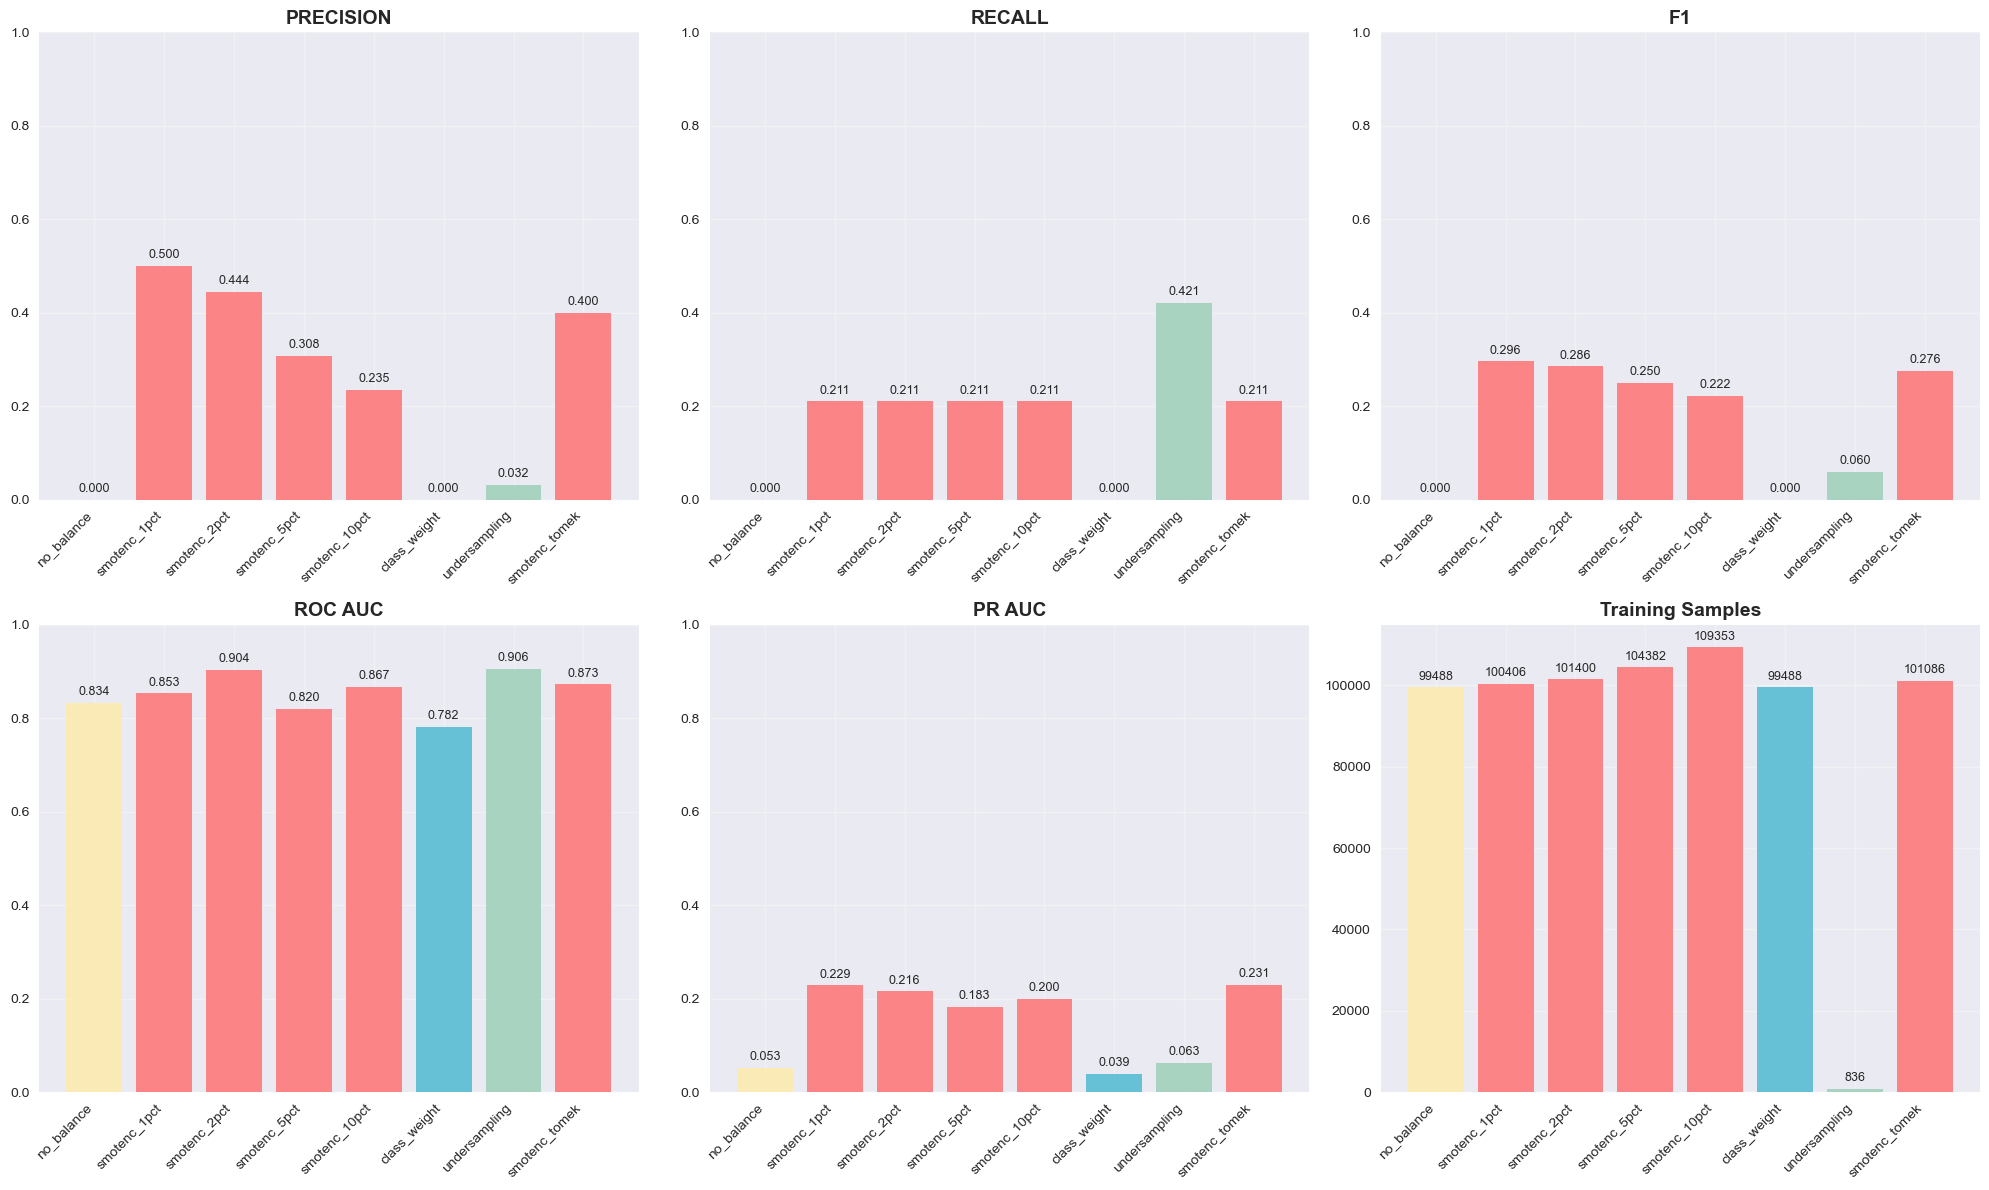

{'class_weight': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0},
 'no_balance': {'f1': 0.0, 'precision': 0.0, 'recall': 0.0},
 'smotenc_10pct': {'f1': 0.2222222222222222,
                   'precision': 0.23529411764705882,
                   'recall': 0.21052631578947367},
 'smotenc_1pct': {'f1': 0.2962962962962963,
                  'precision': 0.5,
                  'recall': 0.21052631578947367},
 'smotenc_2pct': {'f1': 0.2857142857142857,
                  'precision': 0.4444444444444444,
                  'recall': 0.21052631578947367},
 'smotenc_5pct': {'f1': 0.25,
                  'precision': 0.3076923076923077,
                  'recall': 0.21052631578947367},
 'smotenc_tomek': {'f1': 0.27586206896551724,
                   'precision': 0.4,
                   'recall': 0.21052631578947367},
 'undersampling': {'f1': 0.05970149253731343,
                   'precision': 0.0321285140562249,
                   'recall': 0.42105263157894735}}


In [14]:
df_raw = df.copy()
results, categorical_columns, label_encoders = experimento(df_raw)
import pprint
pprint.pprint({
    name: {
        'f1':        v['f1'],
        'recall':    v['recall'],
        'precision': v['precision']
    }
    for name, v in results.items()
})


> Haremos una ingeniería de características que soporte este problema:

- Lag1, lag2:
El correlograma (ACF) muestra autocorrelaciones elevadas en los primeros rezagos: el lag 1 de 0,8 y el lag 2 de 0,6. Esto indica que el valor de hoy depende fuertemente de los dos días previos. Incluir lag1 y lag2 hace que los modelos supervisados (Random Forest, XGBoost, etc.) o las redes recurrentes dispongan explícitamente de esa memoria inmediata

- Medias móviles (ma3, ma7): El panel de Tendencia exhibe oscilaciones suaves superpuestas a un ciclo semanal evidente (panel Estacionalidad).

- ma3 filtra ruido de muy corto plazo, capturando la micro‑tendencia diaria.

- ma7 resume el comportamiento en el horizonte de una semana, alineándose con el patrón estacional de 7 días.
Estas variables suavizadas estabilizan la serie y ayudan a los modelos a centrarse en la señal siguente

In [15]:
d_f = df.copy()
d_f['date']      = pd.to_datetime(d_f['date'])
d_f['year']      = d_f['date'].dt.year
d_f['month']     = d_f['date'].dt.month
d_f['dayofweek'] = d_f['date'].dt.dayofweek
d_f['day']       = d_f['date'].dt.day
d_f['hour']      = d_f['date'].dt.hour
df_featured = innge_de_features(d_f)
X_train_orig, X_test_orig, y_train_orig, y_test, \
    cat_idx, categorical_columns, label_encoders = preparandonos(df_featured)
print("Particiones →",
      "Train:", X_train_orig.shape,
      "Test: ", X_test_orig.shape)
print("Categorical columns:", categorical_columns)
print("Categorical indices:",    cat_idx)




Haremos un poco de Ingeniería de Features
Dataset con features: (124361, 81)
Nuevas features creadas: 64
Distribución final: Counter({0: 124266, 1: 95})
Categóricas: ['device', 'attribute5_diff']
   - device: 1163 categorías únicas
   - attribute5_diff: 7 categorías únicas
Particiones → Train: (99488, 79) Test:  (24873, 79)
Categorical columns: ['device', 'attribute5_diff']
Categorical indices: [0, 52]


> ¿Cómo estamos de estacionaridad? : dado que para ser estacionaria debe mantener media, varianza y autocorrelación estables a lo largo del tiempo -> los gráficos muestran lo contrario:

date dtype: datetime64[ns]
Tenemos 304 días distintos en la serie.


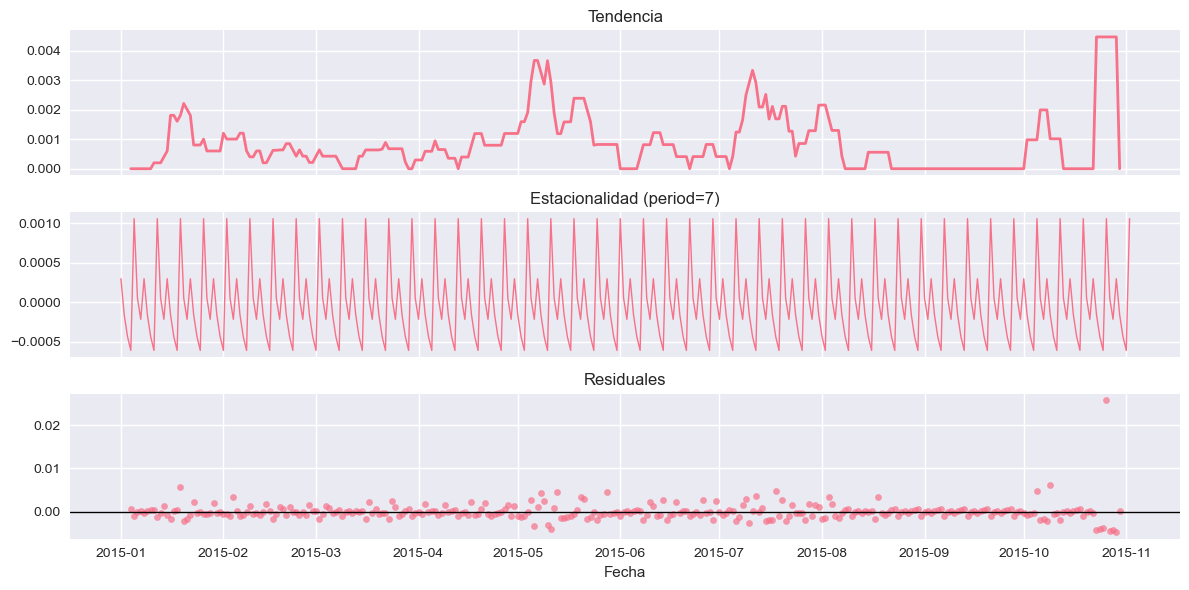

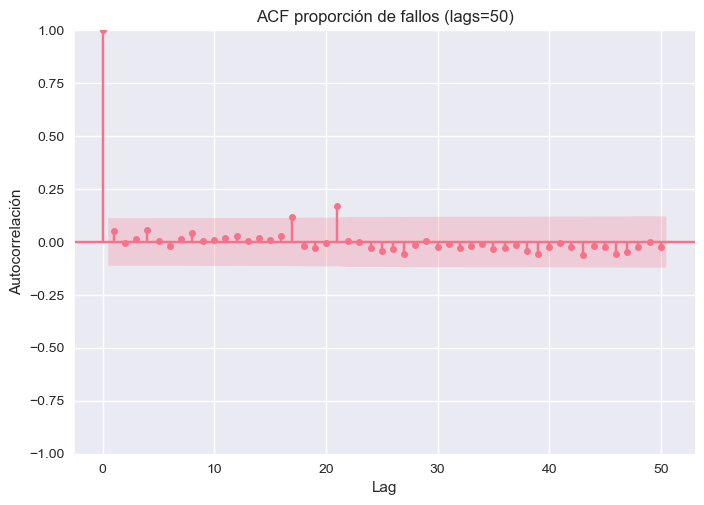

In [16]:
df_featured['date'] = pd.to_datetime({
    'year':  df_featured['year'],
    'month': df_featured['month'],
    'day':   df_featured['day']
})
print("date dtype:", df_featured['date'].dtype)
df_daily = (
    df_featured
      .groupby('date')['failure']
      .mean()
      .rename('avg_failure')
)
print(f"Tenemos {len(df_daily)} días distintos en la serie.")
full_range = pd.date_range(df_daily.index.min(),
                           df_daily.index.max(), freq='D')
df_daily = df_daily.reindex(full_range).fillna(0)

# Ajustamos el period dinámicamente si no hay 2*7 días
period = 7
if len(df_daily) < 2*period:
    period = max(3, len(df_daily)//2)
    print(f"Usando period = {period} en lugar de 7 para poder descomponer.")

decomp = seasonal_decompose(df_daily, model='additive', period=period)

fig, axes = plt.subplots(3, 1, figsize=(12, 6), sharex=True)
axes[0].plot(decomp.trend.index,    decomp.trend,    linewidth=2)
axes[0].set_title('Tendencia')
axes[1].plot(decomp.seasonal.index, decomp.seasonal, linewidth=1)
axes[1].set_title(f'Estacionalidad (period={period})')
axes[2].scatter(decomp.resid.index, decomp.resid, s=20, alpha=0.7)
axes[2].axhline(0, color='black', linewidth=1)
axes[2].set_title('Residuales')
axes[2].set_xlabel('Fecha')
plt.tight_layout()
plt.show()

max_lags = min(50, len(df_daily)-1)
plot_acf(df_daily, lags=max_lags)
plt.title(f"ACF proporción de fallos (lags={max_lags})")
plt.xlabel("Lag"); plt.ylabel("Autocorrelación")
plt.show()

En cuanto a tendencia: la media se desplaza de manera pronunciada, sube, baja y vuelve a subir, prueba clara de que la media no es constante.

Estacionalidad, un ciclo semanal repetitivo introduce estructura periódica, la presencia de estacionalidad viola la suposición de estacionaridad estricta.

En el ACF el correlograma comienza en 1, decae lentamente y presenta un tumulto/hombro alrededor del lag 30 o sea de un mes, reflejo de correlaciones de largo alcance debidas tanto a la tendencia como a la estacionalidad. Si la serie fuera estacionaria la ACF caería rápidamente a cero dentro del margen rosado de confianza

> Ahora, vamos a preparar los datos para aplicar SMOTENC y corregir el desbalanceo de clases incluyendo la variable categórica device. Primero se selecciona todas las columnas útiles para el modelo (excluyendo identificadores y la variable objetivo), luego crea una copia de entrenamiento que incluye device y las demás features. Si device es de tipo objeto, lo transforma con un LabelEncoder y calcula su posición como índice categórico. A continuación instancia SMOTENC con ese índice, especifica que la clase minoritaria alcance el 10 % del tamaño de la mayoritaria y genera nuevos ejemplos sintéticos. Finalmente reconstruye dos objetos: X_res con las features balanceadas y y_train_res con las etiquetas correspondientes.

In [17]:
feature_columns = [
    c for c in df_featured.columns
    if c not in ("device", "failure", "date", "timestamp")
]
oversamp_cols = ['device'] + feature_columns
X_train_os = X_train_orig[oversamp_cols].copy()
if X_train_os['device'].dtype == object:
    X_train_os['device'] = label_encoders['device'].transform(
        X_train_os['device'].astype(str)
    )
cat_idx = [oversamp_cols.index('device')]
print("Categorical indices for SMOTENC:", cat_idx)
sm = SMOTENC(
    categorical_features=cat_idx,
    sampling_strategy=0.10,
    random_state=42
)
X_res, y_res = sm.fit_resample(X_train_os, y_train_orig)
print("Después SMOTENC →", X_res.shape)
X_res = pd.DataFrame(X_res, columns=oversamp_cols)
y_train_res = pd.Series(y_res, name="failure")
print("Conteo de clases en failure:")
print(y_train_res.value_counts())
print('Listo X_res y y_train_res')

Categorical indices for SMOTENC: [0]
Después SMOTENC → (109353, 78)
Conteo de clases en failure:
failure
0    99412
1     9941
Name: count, dtype: int64
Listo X_res y y_train_res


> Este bloque toma los datos sobrremuestreados por SMOTENC, elimina la columna categórica device para quedarse solo con las features numéricas, aplica un StandardScaler ajustado sobre el conjunto de entrenamiento y transforma también el de prueba

In [18]:
X_train_final = X_res.drop('device', axis=1)
X_test_final = X_test_orig.copy()
X_test_final = X_test_final[feature_columns]
scaler = StandardScaler()
X_train = pd.DataFrame(
    scaler.fit_transform(X_train_final),
    columns=feature_columns,
    index=X_train_final.index
)
X_test = pd.DataFrame(
    scaler.transform(X_test_final),
    columns=feature_columns,
    index=X_test_final.index
)


Vamos ahora a ejecutar los modelos:

**Random Forest**
Modelo de bosque aleatorio con énfasis en evitar el sobreajuste y tratar el desbalance.
Parámetros clave:

- class_weight="balanced": ajusta automáticamente los pesos de clase inversamente proporcional a sus frecuencias.

- max_depth=4, min_samples_split=30, min_samples_leaf=20: controlan la complejidad para reducir el sobreajuste.

- max_features=0.4, n_estimators=200: promueven diversidad y estabilidad en los árboles

**XGBoost**
Modelo de boosting robusto con partición estratificada y regularización explícita.
Parámetros clave:

- scale_pos_weight=ratio: compensa clases desbalanceadas usando la proporción entre clases

- reg_alpha=2.0, reg_lambda=2.0, gamma=2.0: aplican regularización L1/L2 y control de complejidad

- subsample=0.7, colsample_bytree=0.5: reducen el riesgo de sobreajuste

- eval_metric="auc": métrica adecuada para clasificación desbalanceada

**Gradient Boosting**
Boosting clásico con pesos de clase explícitos y poda controlada.
Parámetros clave:

- sample_weight=compute_sample_weight('balanced', y_train): pondera el entrenamiento según distribución de clases.

- max_depth=3, min_samples_leaf=15: previene árboles demasiado específicos.

- subsample=0.7: introduce aleatoriedad para mayor generalización

**HistGradientBoosting**
Versión eficiente de boosting con histogramas y control granular del desbalance.
Parámetros clave:

- class_weight={0: 1.0, 1: ratio*1.10}: aumenta ligeramente el peso de la clase minoritaria.

- early_stopping=True y validation_fraction=0.15: detiene el entrenamiento ante sobreajuste.

- l2_regularization=5.0: penaliza modelos complejos para generalizar mejor

**LightGBM Regularizado**
Boosting basado en histogramas y hojas, con énfasis en generalización para clases desbalanceadas.
Parámetros clave:

- scale_pos_weight=ratio: compensa el desbalance de clases.

- early_stopping y eval_metric="aucpr": evalúa la capacidad del modelo con métricas robustas para desbalance.

- reg_alpha=1.0, reg_lambda=1.0: regularización L1 y L2 para evitar sobreajuste

**Ensamble Regularizado**
Combinación de Random Forest, XGBoost y HistGradientBoosting para robustez y diversidad.
Parámetros clave:

- VotingClassifier(voting='soft'): pondera probabilidades para una mejor agregación.

- Submuestreo del 70% de los datos para entrenamiento (X_sub): mejora generalización.

- Cada modelo base ha sido previamente ajustado para desbalance con técnicas propias.

In [19]:
models = {
    'RF'      : modelo_rfc(X_train, y_train_res),
    'XGB'     : modelo_xgb(X_train, y_train_res),
    'GB'      : modelo_gb(X_train, y_train_res),
    'HGB'     : modelo_hgb(X_train, y_train_res),
    'LGBM'    : modelo_lgbm(X_train, y_train_res),
    'Ensamble': ensamblandoAndo(X_train, y_train_res)[0]
}

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[1000]	valid_0's binary_logloss: 0.0163714


In [20]:
best_model, best_result, df_comparacion = comparacion(
    models,
    X_train, y_train_res,
    X_test,  y_test
)


>>> Evaluando RF
Fit 15.921s | Train F1 0.855 – Test F1 0.024

>>> Evaluando XGB
Fit 2.602s | Train F1 0.980 – Test F1 0.070

>>> Evaluando GB
Fit 13.558s | Train F1 0.963 – Test F1 0.096

>>> Evaluando HGB
Fit 11.615s | Train F1 0.993 – Test F1 0.127

>>> Evaluando LGBM
Fit 4.350s | Train F1 0.982 – Test F1 0.079

>>> Evaluando Ensamble
Fit 41.517s | Train F1 0.982 – Test F1 0.090

=== Tabla comparativa ===


,precision_train,recall_train,f1_train,auc_train,precision,recall,f1,auc,weighted_score,fit_time
model,,,,,,,,,,
RF,0.771,0.959,0.855,0.989,0.012,0.474,0.024,0.783,0.362,15.921
XGB,0.962,0.998,0.980,1.000,0.040,0.263,0.070,0.735,0.312,2.602
GB,0.978,0.949,0.963,0.998,0.062,0.211,0.096,0.766,0.319,13.558
HGB,0.987,0.999,0.993,1.000,0.083,0.263,0.127,0.673,0.316,11.615
LGBM,0.967,0.998,0.982,1.000,0.047,0.263,0.079,0.753,0.321,4.350
Ensamble,0.966,0.998,0.982,1.000,0.052,0.316,0.090,0.801,0.352,41.517



Mejor modelo: RF (score 0.362)


Dado que nuestro objetivo principal es no perdernos casos de falla , la métrica clave aquí es el recall. El Random Forest alcanza un recall de 0.474, considerablemente por encima de los demás (el siguiente mejores es el ensamblado con 0.316), y además mantiene un AUC sólido (0.783) y el puntaje ponderado más alto (0.362). Aunque su precisión es baja (0.012), este trade‑off es aceptable cuando la prioridad es detectar tantas fallas como sea posible. Por tanto, Random Forest es la opción recomendada para este problema desbalanceado

In [21]:
best_model = modelo_hgb(X_train, y_train_res)
best_model

HistGradientBoostingClassifier(class_weight={0: 1.0, 1: 11.000221305703652},
                               early_stopping=True, l2_regularization=5.0,
                               learning_rate=0.015, max_bins=128, max_iter=600,
                               n_iter_no_change=30, random_state=42,
                               validation_fraction=0.15)

In [23]:
import os
import joblib 
output_dir = r"C:\Users\usuario\Desktop\meli_reto3\deploy\models"
os.makedirs(output_dir, exist_ok=True)
model_path = os.path.join(output_dir, "best_model.pkl")
joblib.dump(best_model, model_path)
print(f"Modelo guardado correctamente en:\n{model_path}")


Modelo guardado correctamente en:
C:\Users\usuario\Desktop\meli_reto3\deploy\models\best_model.pkl


> Vamos ahora a usar el mejor modelo para poder predecir la probabilidad de que falle un día antes de su posible falla

In [22]:
feature_cols = [
    c for c in df_featured.columns 
    if c not in ("device", "failure", "date", "timestamp")
]
result = prediciendo_el_futuro_sklearn(
    model        = best_model,
    scaler       = scaler,
    df           = df_featured,
    device_id    = "S1F01R2B",
    feature_cols = feature_cols,
    seq_len      = 5,
    thresh       = 0.5,
    date_col     = "timestamp"
)

print(result)


     device  next_step  probability  pred_class  confidence
0  S1F01R2B        223     0.239832           0    0.520337
